In [1]:
import pandas as pd
from sklearn.datasets import load_wine
from sklearn.preprocessing import StandardScaler
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from pomegranate import GeneralMixtureModel, LogNormalDistribution, GammaDistribution, NormalDistribution
from sklearn.model_selection import train_test_split
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import adjusted_mutual_info_score
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import MinMaxScaler

from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore")


wine = load_wine()
df = pd.DataFrame(wine.data, columns=wine.feature_names)

In this section we'll check for performance increase when apply two kinds of data transformation:

1. Apply a standard scaler to the data
2. TODO: Add a PCA transformation to the data
3. TODO: Evaluate the clusters. Aske mentioned something with variance.

In [2]:
# Standardize the data
scaler = MinMaxScaler()
data = {
    "scaled": pd.DataFrame(scaler.fit_transform(df), columns=df.columns) + 0.001,
    "raw": df}

# add pca transformed data
for dimension in range(1, len(wine.feature_names)):
    pca = PCA(n_components=dimension)
    data[f"pca_{dimension}"] = pd.DataFrame(pca.fit_transform(data['scaled']), columns=[f"pca_{i}" for i in range(dimension)])

for key in data.keys():
    data[key]["target"] = wine.target

In [3]:
for datatype in data:
    if not data[datatype].min().min() < 0:
        print(f'{datatype} dont have negative values')

scaled dont have negative values
raw dont have negative values


# How many clusters?

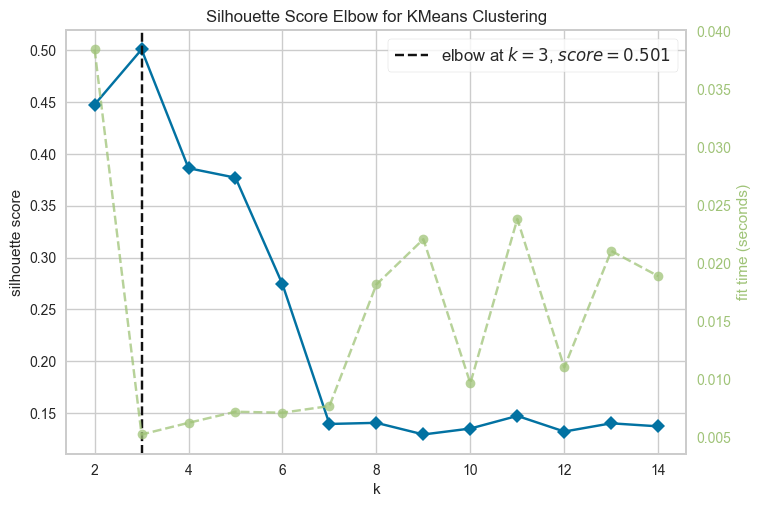

<AxesSubplot: title={'center': 'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [4]:
visualizer = KElbowVisualizer(KMeans(), k=(2,15), metric='silhouette')
visualizer.fit(data["scaled"])        
visualizer.show()

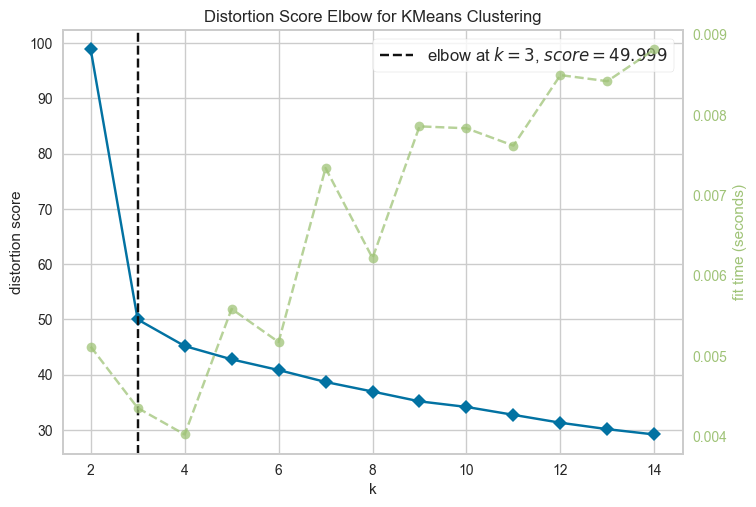

<AxesSubplot: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [5]:
visualizer = KElbowVisualizer(KMeans(), k=(2,15), metric='distortion')
visualizer.fit(data["scaled"])        
visualizer.show()        

# Evaluate all models on k=3

In [6]:
distributions = {
    "lognormal": LogNormalDistribution,
    "gamma":GammaDistribution,
    "normal":NormalDistribution
    }

component = 3

sklearn_models = [
    ("K-Means",KMeans), 
    ("GMM + K-Means",GaussianMixture),
    ("GMM",GaussianMixture),
    ("AGG",AgglomerativeClustering)]

num_iters = 25

results = {'distribution':[],
           'mutual_information':[],
           'datatype':[]}

for datatype, df in data.items():

    features, labels = df.drop('target', axis=1, inplace=False), df['target']
        
    for iteration in range(num_iters):
        
        X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, stratify=labels)

        for name, distribution in distributions.items():
            
            try:
                model = GeneralMixtureModel.from_samples(distribution, n_components=component, X=X_train, )
                model.fit(X_train)
                y_pred = model.predict(X_test)
                score = adjusted_mutual_info_score(y_test, y_pred)  
            
            except ZeroDivisionError:
                print(f'Division Error: {datatype} {name} {component} {iteration}')
                score = 0
            
            except Exception as e:
                print(f'Error: {datatype} {name} {component} {iteration} - {e}')
                score = 0

            results['distribution'].append(name)
            results['mutual_information'].append(score)
            results['datatype'].append(datatype)

        for name, model in sklearn_models:
            
            MODEL = model()

            if name == 'GMM + K-Means':                    
                MODEL.n_components = component
                MODEL.init_params = 'kmeans'
                MODEL.random_state = 32

            if name == 'GMM':
                MODEL.n_components = component
                MODEL.init_params = 'random'
                MODEL.random_state = 32
            
            if name == 'K-Means':
                # kmeans
                MODEL.n_clusters = component
                MODEL.random_state = 32
            
            if name == "AGG":
                MODEL.n_clusters = component


            if name == "AGG":
                y_pred = MODEL.fit_predict(X_test)
            else:
                MODEL.fit(X_train)
                y_pred = MODEL.predict(X_test)

            score = adjusted_mutual_info_score(y_test, y_pred)

            results['distribution'].append(name)
            results['mutual_information'].append(score)
            results['datatype'].append(datatype)
            
results = pd.DataFrame(results)

In [7]:
results

,distribution,mutual_information,datatype
0,lognormal,0.906407,scaled
1,gamma,0.728180,scaled
2,normal,0.811503,scaled
3,K-Means,0.903821,scaled
4,GMM + K-Means,1.000000,scaled
...,...,...,...
2445,normal,0.903564,pca_12
2446,K-Means,0.903821,pca_12
2447,GMM + K-Means,0.905895,pca_12
2448,GMM,0.483854,pca_12


In [8]:
results = results.groupby(['distribution','datatype']).mean().sort_values('mutual_information',ascending=False)
results = results[results["mutual_information"] > 0.1]
results.to_csv("results/rq4-models.csv",index=True)
results

mutual_information
distribution  datatype                    
GMM + K-Means scaled              0.949584
normal        pca_2               0.900285
GMM + K-Means pca_10              0.898666
K-Means       pca_11              0.897818
GMM + K-Means pca_8               0.890184
...                                    ...
GMM           pca_9               0.313808
              pca_10              0.309093
              pca_1               0.290638
              raw                 0.286445
              scaled              0.269673

[74 rows x 1 columns]

In [9]:
pivot_df = results.pivot_table(index='datatype', columns='distribution', values='mutual_information').round(3)
pivot_df= pivot_df.reindex(
    ['raw','scaled','pca_1','pca_2','pca_3','pca_4','pca_5','pca_6','pca_7','pca_8','pca_9','pca_10','pca_11','pca_12'],
    columns=['K-Means','GMM + K-Means','GMM','normal',"AGG",'lognormal','gamma',]
    )
pivot_df.rename(columns={'normal':'N','lognormal':'LN','gamma':'G'}, inplace=True)
pivot_df=pivot_df.fillna('-')
pivot_df.to_latex("results/rq4-models.tex", index=True)
pivot_df

distribution,K-Means,GMM + K-Means,GMM,N,AGG,LN,G
datatype,,,,,,,
raw,0.443,0.572,0.286,0.841,0.435,0.855,0.851
scaled,0.841,0.950,0.270,0.842,0.804,0.789,0.875
pca_1,0.569,0.545,0.291,0.542,0.539,-,-
pca_2,0.847,0.873,0.518,0.900,0.836,-,-
pca_3,0.845,0.854,0.695,0.855,0.780,-,-
pca_4,0.825,0.761,0.466,0.826,0.776,-,-
pca_5,0.794,0.805,0.452,0.831,0.761,-,-
pca_6,0.884,0.868,0.509,0.884,0.815,-,-
pca_7,0.860,0.869,0.458,0.778,0.819,-,-
